In [9]:
import pathlib
import platform
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import adfuller
from sklearn import covariance
from sklearn.linear_model import LassoCV, LinearRegression, RidgeCV
from sklearn.feature_extraction import DictVectorizer
import networkx as nx
from binance.um_futures import UMFutures

from datetime import datetime, timedelta

import warnings
warnings.filterwarnings('ignore')

client = UMFutures()


#### Functions

In [42]:
def calculate_hurst(df):
    ts = df.values

    # Create the range of lag values
    lags = range(2, 100)

    # Calculate the array of the variances of the lagged differences
    tau = [np.sqrt(np.std(np.subtract(ts[lag:], ts[:-lag]))) for lag in lags]

    # Use a linear fit to estimate the Hurst Exponent
    poly = np.polyfit(np.log(lags), np.log(tau), 1)

    # Return the Hurst exponent from the polyfit output
    return poly[0] * 2.0


def calculat_half_life(df):
    df_lag = df.shift(1)
    df_delta = df - df_lag
    lin_reg_model = LinearRegression()
    df_delta = df_delta.values.reshape(len(df_delta),1)                    # sklearn needs (row, 1) instead of (row,)
    df_lag = df_lag.values.reshape(len(df_lag),1)
    lin_reg_model.fit(df_lag[1:], df_delta[1:])                           # skip first line nan
    half_life = -np.log(2) / lin_reg_model.coef_.item()
    return half_life


def calculate_johansen(y, p, crit_val=1):
        """
        Get the cointegration vectors at 95% level of significance
        given by the trace statistic test.
        """

        N, l = y.shape
        jres = coint_johansen(y, 0, p)
        trstat = jres.lr1                       # trace statistic
        tsignf = jres.cvt                       # critical values

        r = 0
        for i in range(l):
            if trstat[i] > tsignf[i, crit_val]:     # 0: 90%  1:95% 2: 99%
                r = i + 1
        jres.r = r
        jres.evecr = jres.evec[:, :r]

        return jres


def get_trades(df, entry, mean, stop):
    trades = []
    positions = [0]
    long_entry = mean - entry
    short_entry = mean + entry
    long_stop = mean - stop
    short_stop = mean + stop
    current_pos = 0
    for i in range(1, len(df)):
        if i == len(df) - 1 and current_pos == 0:
            pass
        elif i == len(df) - 1 and current_pos == -1:
            trades.append({'date': df.index[i], 'trade': 'close short', 'position': 0, 'spread': df.iloc[i]})
        elif i == len(df) - 1 and current_pos == 1:
            trades.append({'date': df.index[i], 'trade': 'close long', 'position': 0, 'spread': df.iloc[i]})
        elif current_pos == 0 and df.iloc[i-1] < long_entry.iloc[i-1] and df.iloc[i] > long_entry.iloc[i]:
            trades.append({'date': df.index[i], 'trade': 'open long', 'position': 1, 'spread': df.iloc[i]})
            current_pos = 1
        elif current_pos == 0 and df.iloc[i-1] > short_entry.iloc[i-1] and df.iloc[i] < short_entry.iloc[i]:
            trades.append({'date': df.index[i], 'trade': 'open short', 'position': -1, 'spread': df.iloc[i]})
            current_pos = -1
        elif current_pos == 1 and df.iloc[i] >= mean.iloc[i]:
            trades.append({'date': df.index[i], 'trade': 'close long', 'position': 0, 'spread': df.iloc[i]})
            current_pos = 0
        elif current_pos == -1 and df.iloc[i] <= mean.iloc[i]:
            trades.append({'date': df.index[i], 'trade': 'close short', 'position': 0, 'spread': df.iloc[i]})
            current_pos = 0
        elif current_pos == -1 and df.iloc[i] >= short_stop.iloc[i]:
            trades.append({'date': df.index[i], 'trade': 'close short', 'position': 0, 'spread': df.iloc[i]})
            current_pos = 0
        elif current_pos == 1 and df.iloc[i] <= long_stop.iloc[i]:
            trades.append({'date': df.index[i], 'trade': 'close long', 'position': 0, 'spread': df.iloc[i]})
            current_pos = 0
        
        positions.append(current_pos)
    
    return (pd.DataFrame(trades), positions)


def filter_universe_graphical_lasso(prices_df, penalty=0.1, display=False):
    # implementation from https://towardsdatascience.com/machine-learning-in-action-in-finance-using-graphical-lasso-to-identify-trading-pairs-in-fa00d29c71a7
    returns = prices_df.pct_change()[1:]

    edge_model = covariance.GraphicalLassoCV()
    returns /= returns.std(axis=0)
    edge_model.fit(returns)
    p = edge_model.precision_

    #prepare the matrix for network illustration
    p = pd.DataFrame(p, columns=prices_df.columns, index=prices_df.columns)
    links = p.stack().reset_index()
    links.columns = ['var1', 'var2','value']
    links=links.loc[ (abs(links['value']) > penalty) &  (links['var1'] != links['var2']) ]

    #build the graph using networkx lib
    G=nx.from_pandas_edgelist(links,'var1','var2', create_using=nx.Graph())
    pos = nx.spring_layout(G, k=0.2*1/np.sqrt(len(G.nodes())), iterations=20)

    if display:
        plt.figure(3, figsize=(10, 10))
        nx.draw(G, pos=pos)
        nx.draw_networkx_labels(G, pos=pos)
        plt.show()
    
    return G


def get_best_pair_candidates(graph, formation_prices_df, nbr_of_candidates=10, min_dollars_per_unit=0, max_dollars_per_unit=99999):
    # Find most mean reverting pairs
    ridge = RidgeCV()
    unique_pairs = []
    possible_pairs = []
    clusters = nx.connected_components(graph)
    
    for cluster in clusters:
        perps = list(cluster)
        for perp_a in perps:
            for perp_b in perps:
                pair = '{}/{}'.format(perp_a, perp_b)
                if perp_a != perp_b and '{}/{}'.format(perp_b, perp_a) not in unique_pairs:
                    
                    # regress prices
                    ridge_reg = ridge.fit(formation_prices_df[perp_a].values.reshape(-1, 1), formation_prices_df[perp_b].values.reshape(-1, 1))
                    beta = ridge_reg.coef_[0][0]

                    if beta < 0:
                        # ignore negative betas, not sure how to interpret them for now
                        continue

                    # test for mean-reversion
                    spread =  formation_prices_df[perp_b] - beta * formation_prices_df[perp_a]
                    half_life = calculat_half_life(spread)
                    adf = adfuller(spread, 1)
                    hurst = calculate_hurst(spread)

                    # calculate positions ratio in dollars
                    total_size = formation_prices_df[perp_b] + ridge_reg.coef_[0][0] * formation_prices_df[perp_a]
                    size_ratio = formation_prices_df[perp_b] / total_size

                    if total_size.mean() < min_dollars_per_unit or total_size.mean() > max_dollars_per_unit:
                        # skip if dollars per unit is not within our limits
                        continue

                    possible_pairs.append({
                        'pair': pair,
                        'perp_a': perp_a,
                        'perp_b': perp_b,
                        'beta_units': ridge_reg.coef_[0][0],
                        'half_life': half_life,
                        'adf_pvalue': adf[1],
                        'hurst': hurst,
                        'long_short_position_ratio': size_ratio.mean()
                    })

                    unique_pairs.append(pair)

    possible_pairs = pd.DataFrame(possible_pairs)
    top_pairs = []
    unique_perps = []
    if len(possible_pairs) > 0:
        for idx in possible_pairs[(possible_pairs['half_life'] > 0)].sort_values(['half_life']).index:
            if len(top_pairs) < nbr_of_candidates:
                if possible_pairs.loc[idx]['perp_a'] not in unique_perps and possible_pairs.loc[idx]['perp_b'] not in unique_perps:
                    top_pairs.append(possible_pairs.loc[idx])
                    unique_perps.append(possible_pairs.loc[idx]['perp_a'])
                    unique_perps.append(possible_pairs.loc[idx]['perp_b'])

    top_pairs_df = pd.DataFrame(top_pairs)
    
    return top_pairs_df


# params = {lasso_penalty, start_date, end_date, minimum_volume_per_bar, formation_period_days, minimum_dollars_per_unit, maximum_dollars_per_unit, trading_period_days, taker_fee, entry_multiple, stop_multiple, half_life_multiple, nbr_max_pairs, display_cluster}
def backtest_mean_reversion_portfolio(prices_df, volumes_df, params, display=False):

    # Narrow down universe
    formation_start_date = params['start_date']
    formation_end_date = formation_start_date + timedelta(days=params['formation_period_days'])
    formation_prices_df = prices_df[formation_start_date:formation_end_date].fillna(method='ffill').T.dropna().T

    sorted_volumes = volumes_df[formation_start_date:formation_end_date].mean().sort_values(ascending = False)
    best_volume_perps = list(sorted_volumes[sorted_volumes >= params['minimum_volume_per_bar']].index)
    formation_prices_df = formation_prices_df.loc[:, formation_prices_df.columns.isin(best_volume_perps)]

    if len(formation_prices_df) == 0:
        return {
            'pairs': pd.DataFrame([]),
            'returns': 0,
            'max_drawdown': 0,
            'individual_pairs': pd.DataFrame([]),
            'individual_trades': pd.DataFrame([])
        }
    graph = filter_universe_graphical_lasso(formation_prices_df, params['lasso_penalty'], params['display_cluster'])

    # Rank and select top pairs based on mean reversion properies
    top_pairs = get_best_pair_candidates(graph, formation_prices_df, params['nbr_max_pairs'], params['minimum_dollars_per_unit'], params['maximum_dollars_per_unit'])

    # Backtest
    trading_start_date = formation_end_date
    trading_end_date = trading_start_date + timedelta(days=params['trading_period_days'])
    trading_prices_df = prices_df[trading_start_date:trading_end_date].fillna(method='ffill').T.dropna().T

    individual_pairs_data = []
    individual_trades_data = []
    portfolio_cumret = None
    for i in range(0, len(top_pairs)):

        row = top_pairs.iloc[i]

        single_pair_result = backtest_mean_reversion_single_pair(row, trading_prices_df, params, False)
        cumret = single_pair_result['cumulative_returns']
        cumdd = single_pair_result['max_drawdown_returns']

        if len(single_pair_result['individual_trades']) > 0:
            individual_trades_data.append(single_pair_result['individual_trades'])
            individual_pairs_data.append(pd.DataFrame({
                'pair': row['pair'],
                'returns': cumret.iloc[-1],
                'max_drawdown': cumdd.iloc[-1]
            }))

            if portfolio_cumret is None:
                portfolio_cumret = cumret/len(top_pairs)
            else:
                portfolio_cumret += cumret/len(top_pairs)
        else:
            individual_pairs_data.append(pd.DataFrame({
                'pair': row['pair'],
                'returns': [0],
                'max_drawdown': [0]
            }))
    if len(individual_pairs_data) > 0:
        individual_pairs_data_df = pd.concat(individual_pairs_data).reset_index(drop=True)
        individual_pairs_data_df['calmar_ratio'] = individual_pairs_data_df['returns'] / abs(individual_pairs_data_df['max_drawdown'])
        # must be more because no drawdown theorically, but prefer to be conservative
        individual_pairs_data_df['calmar_ratio'] = individual_pairs_data_df['calmar_ratio'].replace(np.inf, 1)
    else:
        individual_pairs_data_df = pd.DataFrame([{'pair': [], 'returns': [], 'max_drawdown': [], 'calmar_ratio': []}])

    if len(individual_trades_data) > 0:
        individual_trades_data_df = pd.concat(individual_trades_data).reset_index(drop=True)
    else:
        individual_trades_data_df = pd.DataFrame([])

    # we assume equal dollar size for each pair (if i put 1,000$ in 10 pairs, total return over 10,000$ is the mean of individual pair returns)
    if portfolio_cumret is None:
        portfolio_cum_max_dd = 0
        portfolio_returns = 0
        portfolio_max_dd = 0
        portfolio_avg_calmar_ratio = 0
    else:
        portfolio_cum_max_dd = (portfolio_cumret - portfolio_cumret.cummax()).cummin()
        portfolio_returns = individual_pairs_data_df['returns'].mean()
        portfolio_max_dd = individual_pairs_data_df['max_drawdown'].mean()
        portfolio_avg_calmar_ratio = portfolio_returns / abs(portfolio_max_dd)

    if display:
        plt.figure(figsize=(15,7))
        plt.title('Portfolio Cumulative Returns (%) - Returns = {:.2f}%, Max Drawdown = {:.2f}%, Calmar Ratio = {:.2f}'.format(portfolio_returns*100, portfolio_max_dd*100, portfolio_avg_calmar_ratio))

        if portfolio_cumret is None:
            plt.plot(0)
        else:
            plt.plot(portfolio_cumret*100)
            plt.plot(portfolio_cumret.cummax()*100, color='green')
            plt.plot(portfolio_cum_max_dd*100, color='red')
    
    top_pairs['returns'] = individual_pairs_data_df['returns'].values
    top_pairs['max_drawdown'] = individual_pairs_data_df['max_drawdown'].values
    top_pairs['calmar'] = individual_pairs_data_df['calmar_ratio'].values
    
    return {
        'pairs': top_pairs,
        'returns': portfolio_returns,
        'max_drawdown': portfolio_max_dd,
        'individual_pairs': individual_pairs_data_df,
        'individual_trades': individual_trades_data_df
    }


# params = {start_date, end_date, formation_period_days, trading_period_days, taker_fee, entry_multiple, stop_multiple, half_life_multiple, nbr_max_pairs}
def backtest_mean_reversion_single_pair(pair_data, prices_df, params, display=True):

    taker_fee = params['taker_fee']
    std_entry_multiple = params['entry_multiple']
    std_stop_multiple = params['stop_multiple']
    half_life_multiple = params['half_life_multiple']

    trading_start_date = params['start_date'] + timedelta(days=params['formation_period_days'])
    trading_end_date = trading_start_date + timedelta(days=params['trading_period_days'])
    trading_prices_df = prices_df[trading_start_date:trading_end_date].fillna(method='ffill').T.dropna().T

    # trades
    trading_spread = (trading_prices_df[[pair_data['perp_a'], pair_data['perp_b']]] * [-pair_data['beta_units'], 1]).sum(axis=1)
    position_size = ((trading_prices_df[[pair_data['perp_a'], pair_data['perp_b']]] * [pair_data['beta_units'], 1]).sum(axis=1))
    rolling_mean = trading_spread.rolling(window=int(pair_data['half_life'] * half_life_multiple)).apply(np.mean)
    rolling_std = trading_spread.rolling(window=int(pair_data['half_life'] * half_life_multiple)).apply(np.std)
    rolling_entry = std_entry_multiple * rolling_std
    rolling_stop = std_stop_multiple * rolling_std
    trades, positions = get_trades(trading_spread, rolling_entry, rolling_mean, rolling_stop)

    # individual trade details
    individual_trades = []
    for i in range(0, len(trades)):
        if trades.iloc[i]['position'] != 0:
            unit_position_size = position_size.loc[trades.iloc[i]['date']]
            fee = unit_position_size * taker_fee
            pnl = (trading_spread.loc[trades.iloc[i + 1]['date']] - trading_spread.loc[trades.iloc[i]['date']]) * trades.iloc[i]['position']
            pnl_after_fee = pnl - fee
            ret = pnl_after_fee / position_size.loc[trades.iloc[i]['date']] # return is spread pnl in dollars divided by position value in dollars at open (logic: $ made over $ used for the trade)
            individual_trades.append({
                'pair': pair_data['pair'],
                'date_open': trades.iloc[i]['date'],
                'date_close': trades.iloc[i + 1]['date'],
                'position': trades.iloc[i]['position'],
                'spread_open': trading_spread.loc[trades.iloc[i]['date']],
                'spread_close': trading_spread.loc[trades.iloc[i+1]['date']],
                'beta': pair_data['beta_units'],
                'one_unit_dollar_size': unit_position_size,
                'pnl': pnl,
                'fee': fee,
                'pnl_after_fee': pnl_after_fee,
                'returns': ret,
                'duration': trades.iloc[i + 1]['date'] - trades.iloc[i]['date']
            })
    individual_trades_df = pd.DataFrame(individual_trades)

    if len(individual_trades) > 0:
        # period returns
        cumulative_pnl = individual_trades_df['pnl_after_fee'].cumsum().to_frame()
        max_drawdown_pnl = (cumulative_pnl - cumulative_pnl.cummax()).cummin()
        cumulative_returns = ((individual_trades_df['returns'] + 1).cumprod() - 1).to_frame()
        max_drawdown_returns = (cumulative_returns - cumulative_returns.cummax()).cummin()

        # adjust index
        cumulative_pnl['date'] = individual_trades_df['date_close']
        max_drawdown_pnl['date'] = individual_trades_df['date_close']
        cumulative_returns['date'] = individual_trades_df['date_close']
        max_drawdown_returns['date'] = individual_trades_df['date_close']

        cumulative_pnl = cumulative_pnl.set_index('date')
        max_drawdown_pnl = max_drawdown_pnl.set_index('date')
        cumulative_returns = cumulative_returns.set_index('date')
        max_drawdown_returns = max_drawdown_returns.set_index('date')

        cumulative_pnl = cumulative_pnl.reindex(trading_spread.index).ffill().replace(np.nan, 0)
        max_drawdown_pnl = max_drawdown_pnl.reindex(trading_spread.index).ffill().replace(np.nan, 0)
        cumulative_returns = cumulative_returns.reindex(trading_spread.index).ffill().replace(np.nan, 0)
        max_drawdown_returns = max_drawdown_returns.reindex(trading_spread.index).ffill().replace(np.nan, 0)

    else:
        cumulative_returns = 0,
        max_drawdown_returns = 0
    
    # visualization
    if display:
        fig, axs = plt.subplots(3,1, figsize=(15,10))
        fig.tight_layout()
        axs[0].plot(trading_spread)
        axs[0].title.set_text('{} Spread, -{:.3f} unit(s) of {} for 1 unit of {}, Half-Life = {:.2f} bars'.format(pair_data['pair'], pair_data['beta_units'], pair_data['perp_a'], pair_data['perp_b'], pair_data['half_life']))
        axs[0].plot(rolling_mean, color='grey')
        axs[0].plot(rolling_mean + rolling_entry, color='red')
        axs[0].plot(rolling_mean + rolling_stop, color='black')
        axs[0].plot(rolling_mean - rolling_entry, color='green')
        axs[0].plot(rolling_mean - rolling_stop, color='black')

        if len(individual_trades) > 0:
            axs[0].plot(trading_spread[trades[trades['trade'] == 'open short']['date']], linestyle='None', marker=7, color='r', markersize=10)
            axs[0].plot(trading_spread[trades[trades['trade'] == 'open long']['date']], linestyle='None', marker=6, color='g', markersize=10)
            axs[0].plot(trading_spread[trades[trades['trade'] == 'close short']['date']], linestyle='None', marker=6, color='b', markersize=10)
            axs[0].plot(trading_spread[trades[trades['trade'] == 'close long']['date']], linestyle='None', marker=7, color='b', markersize=10)

            axs[1].plot(cumulative_pnl)
            axs[1].title.set_text('Cumulative PNL')
            axs[1].plot(cumulative_pnl.cummax(), color='green')
            axs[1].plot(max_drawdown_pnl, color='red')

            axs[2].plot(cumulative_returns * 100)
            axs[2].title.set_text('Cumulative Returns (%)')
            axs[2].plot(cumulative_returns.cummax() * 100, color='green')
            axs[2].plot(max_drawdown_returns * 100, color='red')

    return {
        'cumulative_returns': cumulative_returns,
        'max_drawdown_returns': max_drawdown_returns,
        'individual_trades': individual_trades_df
    }    


# params = {lasso_penalty, start_date, end_date, minimum_volume_per_bar, formation_period_days, trading_period_days, taker_fee, entry_multiple, stop_multiple, half_life_multiple, nbr_max_pairs, display_cluster}
def rolling_backtest_mean_reversion(prices_df, volumes_df, params, display=False):
    formation_start_date = params['start_date']
    formation_end_date = formation_start_date + timedelta(days=params['formation_period_days'])
    trading_end_date = formation_end_date + timedelta(days=params['trading_period_days'])

    rolling_pairs_data = []
    rolling_trades = []
    rolling_period_results = []
    period_params = params.copy()
    while trading_end_date <= params['end_date']:
        period_prices_df = prices_df[formation_start_date:trading_end_date].fillna(method='ffill').T.dropna().T
        period_params['start_date'] = formation_start_date
        period_params['end_date'] = trading_end_date
        period_backtest_result = backtest_mean_reversion_portfolio(period_prices_df, volumes_df, period_params)

        rolling_pairs_data.append(period_backtest_result['individual_pairs'])
        if len(period_backtest_result['individual_trades']) > 0:
            rolling_trades.append(period_backtest_result['individual_trades'])

        rolling_period_results.append({
            'period_start': formation_start_date,
            'period_end': trading_end_date,
            'returns': period_backtest_result['returns']
        })

        formation_start_date = formation_start_date + timedelta(days=params['trading_period_days'])
        trading_end_date = trading_end_date + timedelta(days=params['trading_period_days'])

    rolling_pairs_data_df = pd.concat(rolling_pairs_data)
    if len(rolling_trades) > 0:
        rolling_trades_df = pd.concat(rolling_trades)
    else:
        rolling_trades_df = pd.DataFrame([])
    rolling_period_results_df = pd.DataFrame(rolling_period_results)

    backtest_cumulative_returns = ((rolling_period_results_df['returns'] + 1).cumprod() - 1)
    backtest_max_dd = (backtest_cumulative_returns - backtest_cumulative_returns.cummax()).cummin()

    if display:
        ret = backtest_cumulative_returns.iloc[-1]*100
        max_dd = backtest_max_dd.iloc[-1]*100
        bt_start = params['start_date']
        bt_end = params['end_date']

        plt.figure(figsize=(15,7))
        plt.suptitle('Cumulative Returns (%)')
        plt.title('Period: {:%Y-%m-%d} to {:%Y-%m-%d}\nReturns = {:.2f}%, Max Drawdown = {:.2f}%, Calmar Ratio = {:.2f}'.format(bt_start, bt_end, ret, max_dd, ret/abs(max_dd)))

        plt.plot(rolling_period_results_df['period_end'].values, backtest_cumulative_returns.values*100)
        plt.plot(rolling_period_results_df['period_end'].values, backtest_cumulative_returns.cummax().values*100, color='green')
        plt.plot(rolling_period_results_df['period_end'].values, backtest_max_dd.values*100, color='red')

        trade_stats = calculate_trade_statistics(rolling_trades_df)
        if len(trade_stats.keys()) > 0:
            print('{} trades\nLong Ratio: {:.2f}%\nWin Rate: {:.2f}%\nAverage Win: {:.2f}%\nAverage Loss: {:.2f}%\nAverage Trade Duration: {}'.format(trade_stats['nbr_of_trades'], trade_stats['long_ratio']*100, trade_stats['win_rate']*100, trade_stats['avg_win']*100, trade_stats['avg_loss']*100, trade_stats['avg_duration']))
    
    return {
        'returns': backtest_cumulative_returns.iloc[-1],
        'periods_breakdown': rolling_period_results_df,
        'max_drawdown': backtest_max_dd,
        'rolling_pairs_data': rolling_pairs_data_df,
        'rolling_trades': rolling_trades_df
    }


def calculate_trade_statistics(trades):

    if len(trades) > 0:
        return {
            'long_ratio': len(trades[trades['position'] == 1]) / len(trades),
            'win_rate': len(trades[trades['returns'] > 0]) / len(trades),
            'avg_win': trades[trades['returns'] > 0]['returns'].mean(),
            'avg_loss': trades[trades['returns'] < 0]['returns'].mean(),
            'avg_duration': trades['duration'].mean(),
            'sharpe': trades['returns'].mean() / trades['returns'].std(),
            'nbr_of_trades': len(trades)
        }
    else:
        return {}


#### Load data for backtest

In [11]:
# Data
resolution = '15m'

exchange_info = client.exchange_info()
symbols = exchange_info["symbols"]
perps = []
for symbol in symbols:
    if symbol['contractType'] == 'PERPETUAL' and symbol['marginAsset'] == 'USDT':
        perps.append(symbol['symbol'])

ohlc = {}
prices = {}
volumes = {}
for perp in perps:
    data = []
    try:
        if platform.system() == 'Windows':
            data_path = str(pathlib.Path().resolve().parent) + '\\data\\binance'
            data = pd.read_parquet(data_path + '\\{}_{}.parquet.gzip'.format(perp, resolution))
        else:
            data_path = str(pathlib.Path().resolve().parent) + '/data/binance'
            data = pd.read_parquet(data_path + '/{}_{}.parquet.gzip'.format(perp, resolution))
    except:
        print('Cannot find {} data'.format(perp))
    
    if len(data) > 0:
        data['close_time'] = data['close_time'].apply(lambda x: datetime.fromtimestamp(x/1000))
        ohlc[perp] = data.set_index('close_time')
        prices[perp] = ohlc[perp]['close'][ohlc[perp].index.duplicated() == False].astype(float)
        volumes[perp] = ohlc[perp]['volume'][ohlc[perp].index.duplicated() == False].astype(float)


prices_df = pd.DataFrame(prices)
volumes_df = pd.DataFrame(volumes)
prices_df

,BTCUSDT,ETHUSDT,BCHUSDT,XRPUSDT,EOSUSDT,LTCUSDT,TRXUSDT,ETCUSDT,LINKUSDT,XLMUSDT,...,API3USDT,GMTUSDT,APEUSDT,BNXUSDT,WOOUSDT,FTTUSDT,JASMYUSDT,DARUSDT,GALUSDT,OPUSDT
close_time,,,,,,,,,,,,,,,,,,,,,
2019-12-31 19:14:59.999,7176.26,128.87,203.97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-31 19:29:59.999,7172.36,128.75,204.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-31 19:44:59.999,7174.83,128.82,204.64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-31 19:59:59.999,7171.55,128.82,204.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-31 20:14:59.999,7186.60,129.12,205.63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-26 16:29:59.999,20892.40,1371.21,116.00,0.3308,1.082,52.48,0.06472,24.001,6.181,0.10345,...,1.512,0.8562,5.508,119.42,0.16554,26.142,0.00840,0.2741,2.7320,0.7877
2022-07-26 16:44:59.999,20903.30,1371.87,115.98,0.3309,1.081,52.48,0.06474,23.996,6.173,0.10358,...,1.507,0.8548,5.486,119.58,0.16562,26.135,0.00838,0.2734,2.7334,0.7888
2022-07-26 16:59:59.999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.515,0.8588,5.533,119.95,0.16693,26.256,0.00842,0.2747,2.7600,0.7928


#### Backtest

619 trades
Long Ratio: 49.92%
Win Rate: 68.01%
Average Win: 0.81%
Average Loss: -1.35%
Average Trade Duration: 0 days 02:17:38.481421647


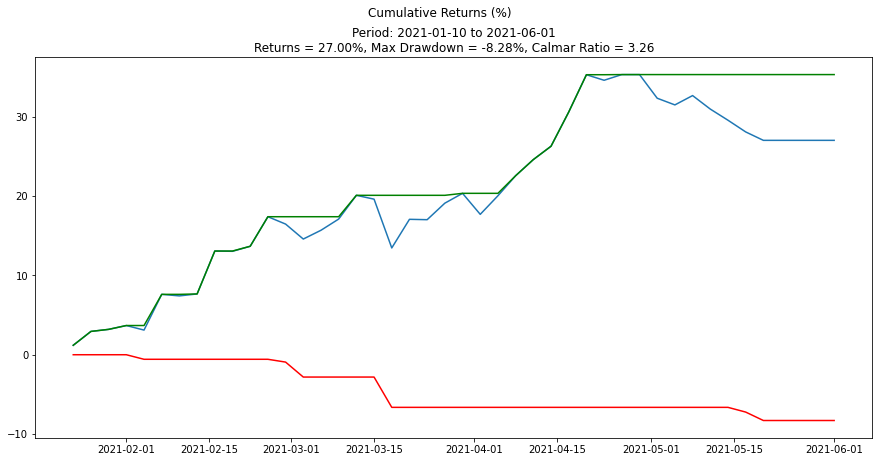

In [51]:
# rolling backest
minimum_24h_volume = 5000000
params = {
    'lasso_penalty': 0.07,
    'minimum_volume_per_bar': minimum_24h_volume / 24 / 4, # based on resolution
    'start_date': datetime.fromisoformat('2021-01-10 00:00:00+00:00'),
    'end_date': datetime.fromisoformat('2021-06-01 00:00:00+00:00'),
    'minimum_dollars_per_unit': 1,
    'maximum_dollars_per_unit': 1000,
    'formation_period_days': 10,
    'trading_period_days': 3,
    'taker_fee': 0.0005,
    'entry_multiple': 2.5,
    'stop_multiple': 4,
    'half_life_multiple': 1,
    'nbr_max_pairs': 3,
    'display_cluster': False
}

backtest_result = rolling_backtest_mean_reversion(prices_df, volumes_df, params, True)

In [47]:
backtest_result['rolling_trades'].sort_values(['returns'])

,pair,date_open,date_close,position,spread_open,spread_close,beta,one_unit_dollar_size,pnl,fee,pnl_after_fee,returns,duration
7,GRTUSDT/ATOMUSDT,2021-05-22 21:14:59.999,2021-05-22 23:59:59.999,-1,-2.255164,-1.746780,18.939862,28.153164,-0.508384,0.014077,-0.522461,-0.018558,0 days 02:45:00
1,CVCUSDT/MANAUSDT,2021-05-20 18:29:59.999,2021-05-20 20:14:59.999,1,-0.114816,-0.135924,2.434145,1.983416,-0.021107,0.000992,-0.022099,-0.011142,0 days 01:45:00
3,BANDUSDT/OCEANUSDT,2021-05-31 03:29:59.999,2021-05-31 06:14:59.999,1,-0.237891,-0.244815,0.088109,1.391011,-0.006923,0.000696,-0.007619,-0.005477,0 days 02:45:00
6,GRTUSDT/ATOMUSDT,2021-05-21 15:29:59.999,2021-05-21 17:14:59.999,1,-2.651899,-2.745856,18.939862,28.401899,-0.093957,0.014201,-0.108158,-0.003808,0 days 01:45:00
4,GRTUSDT/ATOMUSDT,2021-05-20 02:29:59.999,2021-05-20 04:14:59.999,-1,-1.202892,-1.216151,18.939862,31.108892,0.013259,0.015554,-0.002296,-0.000074,0 days 01:45:00
4,ICXUSDT/ONTUSDT,2021-05-30 19:59:59.999,2021-05-30 20:59:59.999,-1,-0.107908,-0.109598,1.099212,2.214508,0.001690,0.001107,0.000583,0.000263,0 days 01:00:00
0,RENUSDT/BATUSDT,2021-05-23 22:44:59.999,2021-05-23 23:59:59.999,-1,0.121813,0.119835,1.231241,1.034187,0.001978,0.000517,0.001460,0.001412,0 days 01:15:00
1,RENUSDT/BATUSDT,2021-05-25 14:29:59.999,2021-05-25 15:59:59.999,1,0.125531,0.128260,1.231241,1.299469,0.002730,0.000650,0.002080,0.001601,0 days 01:30:00
9,OMGUSDT/BELUSDT,2021-05-21 10:59:59.999,2021-05-21 12:44:59.999,-1,-0.680912,-0.689176,0.376887,3.773512,0.008264,0.001887,0.006377,0.001690,0 days 01:45:00
10,OMGUSDT/BELUSDT,2021-05-22 12:29:59.999,2021-05-22 12:44:59.999,-1,-0.496389,-0.504942,0.376887,3.554389,0.008553,0.001777,0.006776,0.001906,0 days 00:15:00


<AxesSubplot:ylabel='Frequency'>

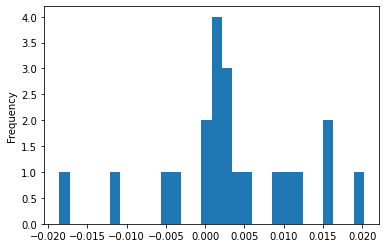

In [48]:
backtest_result['rolling_trades']['returns'].plot.hist(bins=30)

<AxesSubplot:ylabel='Frequency'>

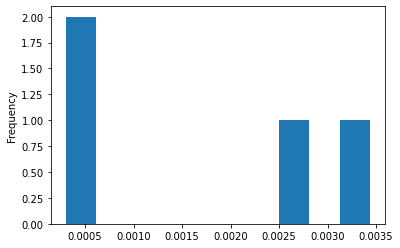

In [49]:
backtest_result['periods_breakdown']['returns'].plot.hist()

In [50]:
backtest_result['periods_breakdown'].sort_values(['returns'])

,period_start,period_end,returns
1,2021-05-13 00:00:00+00:00,2021-05-26 00:00:00+00:00,0.000302
0,2021-05-10 00:00:00+00:00,2021-05-23 00:00:00+00:00,0.000551
2,2021-05-16 00:00:00+00:00,2021-05-29 00:00:00+00:00,0.002597
3,2021-05-19 00:00:00+00:00,2021-06-01 00:00:00+00:00,0.003439


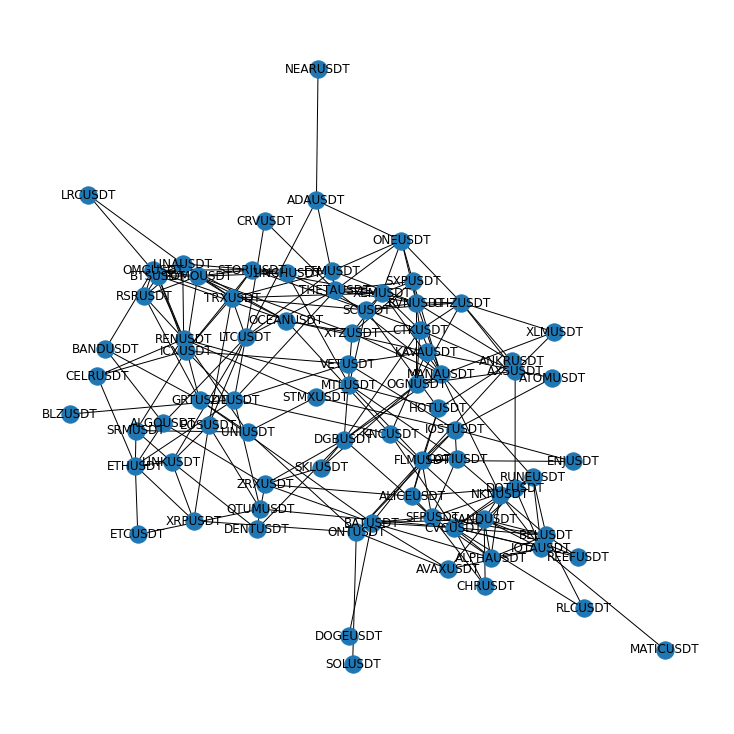

,pair,perp_a,perp_b,beta_units,half_life,adf_pvalue,hurst,long_short_position_ratio,returns,max_drawdown,calmar
1658,SFPUSDT/SXPUSDT,SFPUSDT,SXPUSDT,2.252406,4.348925,1.216861e-06,0.209653,0.470417,0,0,NaN
1431,ONTUSDT/STORJUSDT,ONTUSDT,STORJUSDT,0.771425,4.975117,4.414950e-08,0.149750,0.514234,0,0,NaN
1837,1INCHUSDT/BANDUSDT,1INCHUSDT,BANDUSDT,2.461674,5.188405,3.957016e-13,0.142572,0.518609,0,0,NaN


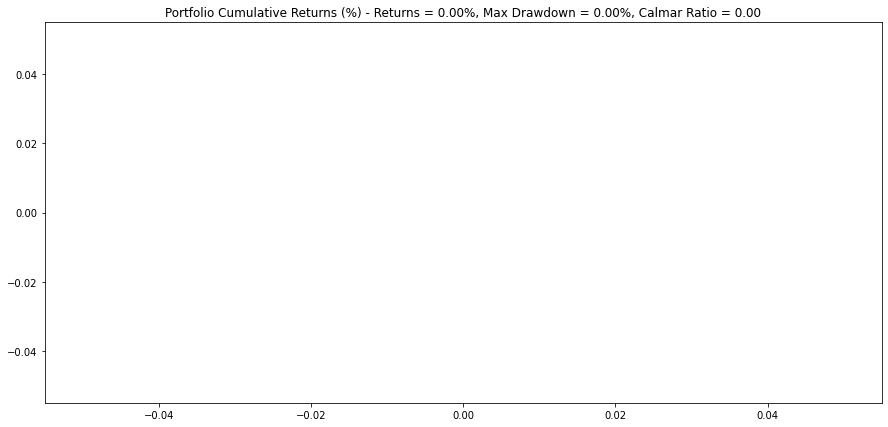

In [37]:
# Backtest
backtest_params = {
    'lasso_penalty': 0.07,
    'minimum_volume_per_bar': minimum_24h_volume / 24 / 4, # based on resolution
    'start_date': datetime.fromisoformat('2021-05-10 00:00:00+00:00'),
    'end_date': datetime.fromisoformat('2021-05-23 00:00:00+00:00'),
    'minimum_dollars_per_unit': 1,
    'maximum_dollars_per_unit': 1000,
    'formation_period_days': 10,
    'trading_period_days': 3,
    'taker_fee': 0.0007,
    'entry_multiple': 2.5,
    'stop_multiple': 4,
    'half_life_multiple': 1,
    'nbr_max_pairs': 3,
    'display_cluster': True
}

res = backtest_mean_reversion_portfolio(prices_df, volumes_df, backtest_params, True)
res['pairs']

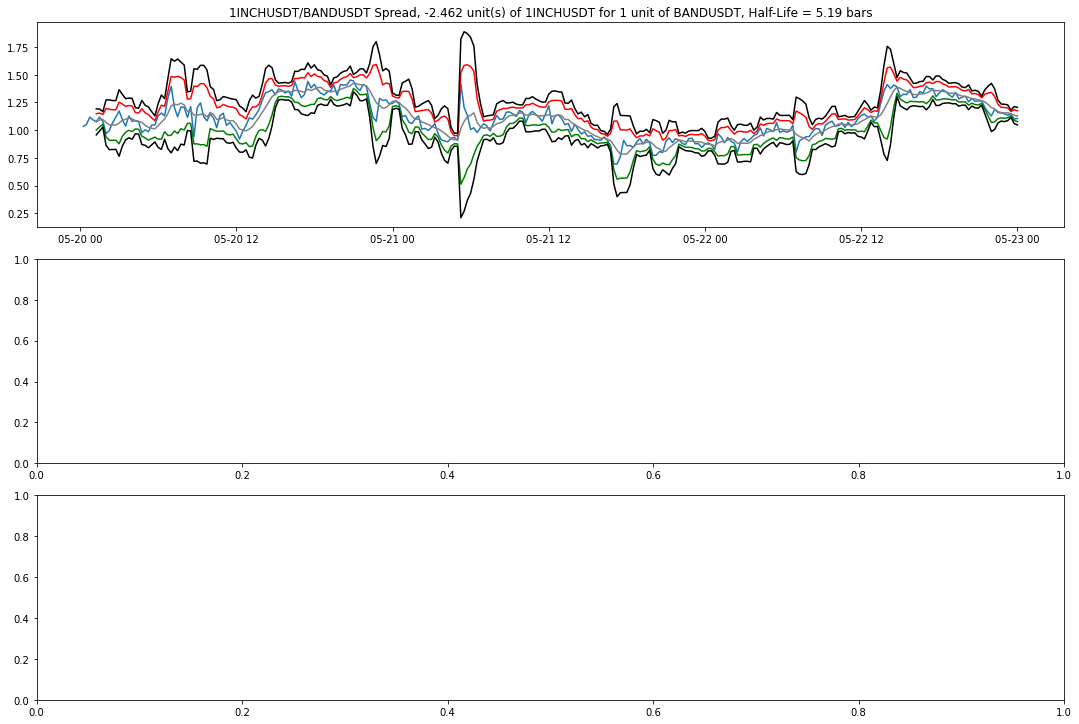

In [45]:
res2 = backtest_mean_reversion_single_pair(res['pairs'].iloc[2], prices_df, backtest_params)